# Analyze dataframes

for all csv-files:
    load dataframe
    find period where only one contender is active

In [1]:
# start by defining a Project name
project = 'medicin_prices'
import os # generel package for interacting with the system
# among other things automate folder creation

subfolders = ['raw_data','parsed_data']

raw_data = os.path.join(project, subfolders[0])
# Special folder that is write protected in order to preserve the original data
raw_data_read_only = os.path.join(project, subfolders[0] + '-read-only')
raw_data_read_only_limited = os.path.join(project, subfolders[0] + '-read-only-lmt')
parsed_data = os.path.join(project, subfolders[1])

In [2]:
# Get all csv files
import glob

def get_csv_files(data_path):
    return glob.glob(os.path.join(data_path, '*.csv'))

In [5]:
from pandas import DataFrame

def find_single_contender_idx(df: DataFrame):
    return df.isnull().sum(axis=1) == df.shape[1] - 1

In [6]:
def clean_dataframe(df: DataFrame):
    # Remove these columns if they are present in the data frame
    unwanted_columns = ['Unnamed: 0', 'tilskudspris']
    for unwanted_column in unwanted_columns:
        if unwanted_column in df.columns:
            df.drop(unwanted_column, axis=1, inplace=True)
    # Convert datetime column into a datetime time and store it in date
    df['date'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y')
    # Drop the datetime column
    df.drop('datetime', axis=1, inplace=True)
    # Set the date column to be the index
    df.set_index('date', inplace=True)
    # Find index set with only one contender
    tmp = df[find_single_contender_idx(df)]
    # There might have been multiple contender from product launch
    if not tmp.empty:
        # Grab the first index of these
        new_start_index = tmp.index.values[0]
        # Slice such that we skip only NaN rows from the start
        df = df[new_start_index:].copy()
    return df

In [7]:
# def pct_change_period(df: DataFrame, periods=2):
#     return [df.pct_change(i) for i in periods]

In [8]:
def find_pct_above_idx(df: DataFrame, threshold=0.5):
    return (df > threshold).sum(axis=1) > 0

In [9]:
def find_pct_change_above(pct_df: DataFrame, threshold=0.5):
    return pct_df.loc[find_pct_above_idx(pct_df, threshold=threshold), :]

In [10]:
csv_files_limited = get_csv_files(raw_data_read_only)

In [11]:
csv_files_limited[:10]

['medicin_prices/raw_data-read-only/076043.csv',
 'medicin_prices/raw_data-read-only/070380.csv',
 'medicin_prices/raw_data-read-only/527140.csv',
 'medicin_prices/raw_data-read-only/373077.csv',
 'medicin_prices/raw_data-read-only/147370.csv',
 'medicin_prices/raw_data-read-only/075494.csv',
 'medicin_prices/raw_data-read-only/536076.csv',
 'medicin_prices/raw_data-read-only/518668.csv',
 'medicin_prices/raw_data-read-only/088392.csv',
 'medicin_prices/raw_data-read-only/057927.csv']

In [12]:
from typing import List
import pandas as pd
import re

# A product number regex matcher
product_number_matcher = re.compile('[0-9]{6}')

def find_all_above_idx(csv_files: List[str], pct_threshold=0.5, periods=2):
    """Run through a list of csv files and find entries above a percentage threshold given a number of periods

    Keyword arguments:
        csv_files     -- A list of paths point to csv files
        pct_threshold -- Percentage threshold that the price hike should be larger than (defaults to 50%, i.e. 0.5)
        periods       -- Periods defines the periods between measurements to compute the percentage difference between.
                         e.g. periods=2, compute between, period 1: x_2 / x_1, period 2: x_3 / x_1
    """
    # Create a dictionary for storing the results
    product_numbers = dict()
    # Keep track of product numbers already processed
    already_processed = []
    # Run throught all the csv files we where given
    for f in csv_files:
        # Find product number
        product_number = product_number_matcher.search(f).group()
        # Check whether the product number has already been processed
        if product_number in already_processed:
            continue
        # Read the csv file
        df = pd.read_csv(f)
        # Clean the data frame
        df = clean_dataframe(df)
        # Check if we have already processed the product number before
        already_processed.extend(df.columns.tolist())
        # Find percentage change over the number of periods
        pct_changed = df.pct_change(periods)
        # Find places where there are only one contender
        single_pct_idx = find_single_contender_idx(pct_changed)
        # Find all periods where the percentage change is above the given threshold
        above_pct = find_pct_above_idx(pct_changed[single_pct_idx], threshold=pct_threshold)
        idxs = find_pct_above_idx(pct_changed[single_pct_idx], threshold=pct_threshold)
        
        # Store the result, if the frame has any True in the index set
        if above_pct.any():
            product_numbers[product_number] = above_pct
    # Return result
    return product_numbers

In [13]:
def find_all_above(csv_files: List[str], pct_threshold=0.5, periods=2):
    """Run through a list of csv files and find entries above a percentage threshold given a number of periods

    Keyword arguments:
        csv_files     -- A list of paths point to csv files
        pct_threshold -- Percentage threshold that the price hike should be larger than (defaults to 50%, i.e. 0.5)
        periods -- Periods defines the periods between measurements to compute the percentage difference between.
                   e.g. periods=2, compute between, period 1: x_2 / x_1, period 2: x_3 / x_1
    """
    # Create a dictionary for storing the results
    product_numbers = dict()
    # Keep track of product numbers already processed
    already_processed = []
    # Run throught all the csv files we where given
    for f in csv_files:
        # Find product number
        product_number = product_number_matcher.search(f).group()
        # Check whether the product number has already been processed
        if product_number in already_processed:
#             print('product number: {} has already been processed, skipping'.format(product_number))
            continue
        # Read the csv file
        df = pd.read_csv(f)
        # Clean the data frame
        df = clean_dataframe(df)
        # Check if we have already processed the product number before
        already_processed.extend(df.columns.tolist())
        # Find percentage change over the number of periods
        pct_changed = df.pct_change(periods)
        # Find places where there are only one contender
        single_pct_frame = pct_changed[find_single_contender_idx(pct_changed)]
        # Find all periods where the percentage change is above the given threshold
        above_pct = find_pct_change_above(single_pct_frame, threshold=pct_threshold)
        above_idx = find_pct_above_idx(single_pct_frame, threshold=pct_threshold)
        # Store the result, if the frame is non empty
        if not above_pct.empty:
            product_numbers[product_number] = {'pct_change': above_pct, 'idx': above_idx}
    # Return result
    return product_numbers

In [14]:
tmp = find_all_above(csv_files_limited, pct_threshold=7.5, periods=10)

In [15]:
def pretty_print_frames(d):
    for pn, frame in d.items():
        if not frame['pct_change'].empty:
            print('Product number: ', pn)
            print(frame['pct_change'])
            print()

In [16]:
pretty_print_frames(tmp)

Product number:  412129
            412129     145077  507563
date                                 
2013-01-07     NaN  99.000000     NaN
2013-01-21     NaN  99.000000     NaN
2013-02-04     NaN  99.000000     NaN
2013-02-18     NaN  99.000000     NaN
2013-03-04     NaN  99.000000     NaN
2013-03-18     NaN  99.275191     NaN
2013-04-01     NaN  96.776854     NaN
2013-04-15     NaN  96.776854     NaN
2013-04-29     NaN  96.776854     NaN
2013-05-13     NaN  96.776854     NaN

Product number:  062826
            062826     081103  084025  497290
date                                         
2013-06-10     NaN   8.828810     NaN     NaN
2013-06-24     NaN  10.130024     NaN     NaN
2013-07-08     NaN  10.130024     NaN     NaN
2014-09-29     NaN  10.551845     NaN     NaN
2014-10-13     NaN  10.551845     NaN     NaN
2014-10-27     NaN  10.551845     NaN     NaN
2014-11-10     NaN  10.551845     NaN     NaN
2014-11-24     NaN   9.551845     NaN     NaN

Product number:  512521
          

In [17]:
work_on = {'483749': tmp['483749']}

In [18]:
work_on['483749']['idx'].head()

date
2006-11-06    False
2006-11-20    False
2006-12-04    False
2006-12-18    False
2007-01-01    False
dtype: bool

In [19]:
work_on['483749']['idx'].index

DatetimeIndex(['2006-11-06', '2006-11-20', '2006-12-04', '2006-12-18',
               '2007-01-01', '2007-01-15', '2007-01-29', '2007-02-12',
               '2007-02-26', '2007-03-12',
               ...
               '2010-12-13', '2010-12-27', '2011-01-10', '2011-01-24',
               '2011-02-07', '2011-02-21', '2011-03-07', '2011-03-21',
               '2011-04-04', '2011-04-18'],
              dtype='datetime64[ns]', name='date', length=117, freq=None)

In [20]:
from datetime import datetime
from datetime import timedelta

def add_periods(date: datetime, periods: int) -> datetime:
    number_of_days_to_add = periods * 14
    return date + timedelta(days=number_of_days_to_add)

def extraction_period(date: datetime, periods: int=6) -> (datetime, datetime):
    return (add_periods(date, -periods), add_periods(date, periods))

In [21]:
work_on['483749']['idx'].index[0]

Timestamp('2006-11-06 00:00:00')

In [22]:
start_ts = work_on['483749']['idx'].index[0]

In [23]:
start_plus_one = add_periods(start_ts, 1)

In [24]:
test_date_extraction = extraction_period(start_ts, 2)

In [25]:
test_date_extraction

(Timestamp('2006-10-09 00:00:00'), Timestamp('2006-12-04 00:00:00'))

In [26]:
start_plus_one

Timestamp('2006-11-20 00:00:00')

In [27]:
work_on['483749']['idx'][start_plus_one]

False

In [28]:
def generate_csv_filename(product_number: str) -> str:
    return '{}.csv'.format(product_number)

generate_csv_filename('423565')

'423565.csv'

In [59]:
aboves_idx = work_on['483749']['idx'][work_on['483749']['idx'] == True]

In [60]:
aboves_idx

date
2010-12-13    True
2010-12-27    True
2011-01-10    True
2011-01-24    True
2011-02-07    True
2011-02-21    True
2011-03-07    True
2011-03-21    True
2011-04-04    True
2011-04-18    True
dtype: bool

In [31]:
# test_gen_csv = [os.path.join(raw_data_read_only, generate_csv_filename(product_number)) for product_number in tmp.keys()]
test_gen_csv = [os.path.join(raw_data_read_only, generate_csv_filename(product_number)) for product_number in work_on.keys()]

In [32]:
n = list(work_on.keys())[0]
n

'483749'

In [58]:
work_on[n]['pct_change']

,483749,006115,051947
date,,,
2010-12-13,NaN,8.999907,NaN
2010-12-27,NaN,8.999907,NaN
2011-01-10,NaN,8.999907,NaN
2011-01-24,NaN,8.999907,NaN
2011-02-07,NaN,8.999907,NaN
2011-02-21,NaN,8.990793,NaN
2011-03-07,NaN,8.990793,NaN
2011-03-21,NaN,8.990793,NaN
2011-04-04,NaN,8.990793,NaN


In [50]:
work_on[n]['idx'].head()

date
2006-11-06    False
2006-11-20    False
2006-12-04    False
2006-12-18    False
2007-01-01    False
dtype: bool

In [51]:
work_on[n]['idx'].tail()

date
2011-02-21    True
2011-03-07    True
2011-03-21    True
2011-04-04    True
2011-04-18    True
dtype: bool

In [52]:
test_df = pd.read_csv(test_gen_csv[0])
test_df = clean_dataframe(test_df)

In [55]:
test_df.shape

(344, 3)

In [54]:
test_df.tail()

,483749,006115,051947
date,,,
2019-06-17,NaN,4948.35,4948.35
2019-07-01,NaN,4948.35,4948.35
2019-07-15,NaN,4948.35,4948.35
2019-07-29,NaN,4948.35,4948.35
2019-08-12,NaN,4948.35,4948.35


In [165]:


sus_periods = [extraction_period(date_idx, periods=4) for date_idx in aboves_idx.index]

sus_periods

[(Timestamp('2010-10-18 00:00:00'), Timestamp('2011-02-07 00:00:00')),
 (Timestamp('2010-11-01 00:00:00'), Timestamp('2011-02-21 00:00:00')),
 (Timestamp('2010-11-15 00:00:00'), Timestamp('2011-03-07 00:00:00')),
 (Timestamp('2010-11-29 00:00:00'), Timestamp('2011-03-21 00:00:00')),
 (Timestamp('2010-12-13 00:00:00'), Timestamp('2011-04-04 00:00:00')),
 (Timestamp('2010-12-27 00:00:00'), Timestamp('2011-04-18 00:00:00')),
 (Timestamp('2011-01-10 00:00:00'), Timestamp('2011-05-02 00:00:00')),
 (Timestamp('2011-01-24 00:00:00'), Timestamp('2011-05-16 00:00:00')),
 (Timestamp('2011-02-07 00:00:00'), Timestamp('2011-05-30 00:00:00')),
 (Timestamp('2011-02-21 00:00:00'), Timestamp('2011-06-13 00:00:00'))]

In [166]:
sus_periods[0][1]

Timestamp('2011-02-07 00:00:00')

In [155]:
sus_periods[0][1] < sus_periods[1][1]

True

In [170]:
from typing import Tuple
from copy import deepcopy

def merge_periods(dates: List[Tuple[datetime, datetime]]) -> List[Tuple[datetime, datetime]]:
    """Function for merging time periods if they overlap, takes a list of tuples containing datetime elements.

    Keyword arguments:
        dates -- A list of tuples containing datetime elements. The function takes two consecutive tuples t1 and t2
                 and merges them into a single tuple if the second date in t1, i.e. t1[1] is 

    """
    def date_intersection(dt1: datetime, dt2: datetime) -> bool:
        return dt1[1] > dt2[0] and dt1[1] < dt2[1]
    
    def merge_tuple(t1: Tuple[datetime, datetime], t2: Tuple[datetime, datetime]) -> Tuple[datetime, datetime]:
        # create a new tuple with t1 = (start_datetime1, end_datetime1), t2 = (start_datetime1, end_datetime2)
        # return (start_datetime1, end_datetime2)
        return (t1[0], t2[1])
    
    def has_intersections(date_list):
        intersects = []
        for i in range(len(date_list)-1):
            d1 = date_list[i]
            d2 = date_list[i+1]
            dates_intersects = date_intersection(d1, d2)
            intersects.append(dates_intersects)
        any_intersections = any(intersects)
        return any(intersects)

    compute_list = deepcopy(dates)
    # Sanity check, does our list of dates contain more than one tuple
    if len(compute_list) == 1:
        return compute_list
    
    while has_intersections(compute_list):
        # Extract two dates tuples, date1 = (datetime1, datetime2)
        date1 = compute_list.pop(0)
        date2 = compute_list.pop(0)
        # does the dates tuples intersect / is there overlap in the time period?
        if date_intersection(date1, date2):
            # The two dates overlapped, merge them into a new date tuple
            new_date = merge_tuple(date1, date2)
            # Append the new date tuple to the list
            compute_list.append(new_date)
        else:
            # No overlap was found, simply append the dates to the end of the list (we pop from the start of the list)
            compute_list.append(date1)
            compute_list.append(date2)
        # We have merged everything except for one element, hence we need to break the while loop
        if len(compute_list) == 1:
            break
    # Return the merged result
    return compute_list

In [171]:
test_date_merger = merge_periods(sus_periods)

In [174]:
period = test_date_merger[0]
period

(Timestamp('2010-10-18 00:00:00'), Timestamp('2011-06-13 00:00:00'))

In [64]:
test_df.loc[aboves_idx.index]

,483749,006115,051947
date,,,
2010-12-13,NaN,5376.05,5401.00
2010-12-27,NaN,5376.05,5401.00
2011-01-10,NaN,5376.05,5401.00
2011-01-24,NaN,5376.05,5401.00
2011-02-07,NaN,5376.05,5401.00
2011-02-21,NaN,5371.15,5396.05
2011-03-07,NaN,5371.15,5396.05
2011-03-21,NaN,5371.15,5396.05
2011-04-04,NaN,5371.15,5396.05


In [175]:
test_me = test_df[period[0]:period[1]]
test_me

,483749,006115,051947
date,,,
2010-10-18,NaN,537.61,NaN
2010-11-01,NaN,537.61,NaN
2010-11-15,NaN,537.61,NaN
2010-11-29,NaN,537.61,NaN
2010-12-13,NaN,5376.05,5401.00
2010-12-27,NaN,5376.05,5401.00
2011-01-10,NaN,5376.05,5401.00
2011-01-24,NaN,5376.05,5401.00
2011-02-07,NaN,5376.05,5401.00


In [178]:
test_me = test_df[period[0]:'2018-08-27']
test_me

,483749,006115,051947
date,,,
2010-10-18,NaN,537.61,NaN
2010-11-01,NaN,537.61,NaN
2010-11-15,NaN,537.61,NaN
2010-11-29,NaN,537.61,NaN
2010-12-13,NaN,5376.05,5401.00
2010-12-27,NaN,5376.05,5401.00
2011-01-10,NaN,5376.05,5401.00
2011-01-24,NaN,5376.05,5401.00
2011-02-07,NaN,5376.05,5401.00


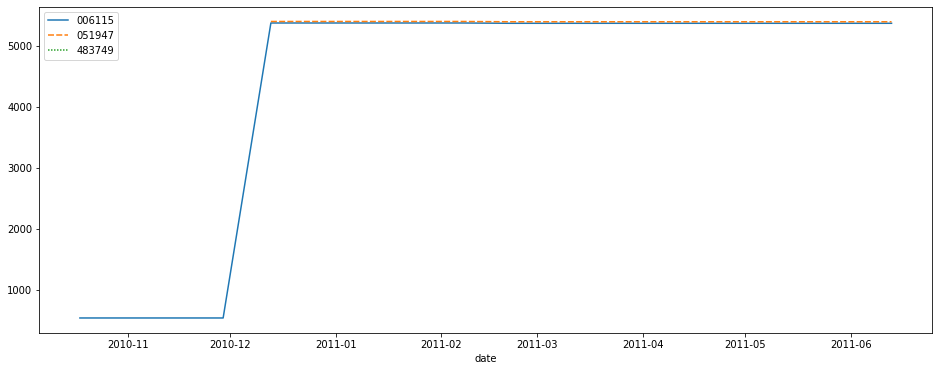

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,6))
sns.lineplot(data=test_me)


In [114]:
test_df[sus_periods[1][0]:sus_periods[1][1]]

,170298
date,
2019-05-20,45.11
2019-06-03,45.11
2019-06-17,45.11
2019-07-01,45.11
2019-07-15,45.11
2019-07-29,435.97
2019-08-12,435.97


In [73]:
sorted(test_gen_csv)[:10]

['medicin_prices/raw_data-read-only/170298.csv']

In [ ]:
def plot_and_save(suspicious_dict):
    for product_number, content in suspicious_dict.items():
        filename = os.path.join(raw_data_read_only, generate_csv_filename(product_number))
        # Read csv file
        df = pd.read_csv(filename)
        # Clean the data frame
        df = clean_dataframe(df)
        

In [29]:
test.iloc()

In [28]:
# This looks interesting, we have a price spike of 460% in the beginning of 2018
# ramipril_10mg_100stk = '138091'
# csv_file = ramipril_10mg_100stk + '.csv'

In [134]:


# This looks interesting, we have a price spike of 460% in the beginning of 2018
ramipril_10mg_100stk_df = pd.read_csv(os.path.join(raw_data_read_only, '138091.csv'))
lansoprazol_30mg_28stk_df = pd.read_csv(os.path.join(raw_data_read_only, '164584.csv'))
# losartanka_ = pd.read_csv(os.path.join(raw_data_read_only, '189624.csv'))
costad_20p5mgml_3x5ml = pd.read_csv(os.path.join(raw_data_read_only, '594005.csv'))

# Losartanka 189624 - 100+12,5 mg - 28 stk

# Costad 594005 - 20+5 mg/ml - 3 x 5 ml


In [135]:
ramipril_10mg_100stk_df.head()

,Unnamed: 0,datetime,tilskudspris,138091,377587,483121,490176,503096
0,251,16.07.2007,1.12,NaN,NaN,NaN,NaN,NaN
1,252,30.07.2007,1.01,NaN,NaN,NaN,NaN,NaN
2,253,13.08.2007,0.90,NaN,NaN,NaN,NaN,NaN
3,254,27.08.2007,0.86,NaN,NaN,NaN,NaN,NaN
4,255,10.09.2007,0.82,NaN,NaN,NaN,NaN,NaN


In [138]:
ramipril_10mg_100stk_df = clean_dataframe(ramipril_10mg_100stk_df)

In [139]:
ramipril_10mg_100stk_df.head()

,138091,377587,483121,490176,503096
date,,,,,
2011-04-18,NaN,NaN,NaN,NaN,1.13
2011-05-02,NaN,NaN,NaN,NaN,1.03
2011-05-16,NaN,NaN,NaN,NaN,0.95
2011-05-30,NaN,NaN,NaN,NaN,0.90
2011-06-13,NaN,NaN,NaN,NaN,0.90


In [158]:
ramipril_10mg_100stk_df.tail()

,138091,377587,483121,490176,503096
date,,,,,
2019-06-17,2.12,NaN,2.18,NaN,2.01
2019-07-01,1.40,NaN,1.37,NaN,1.51
2019-07-15,1.13,1.09,1.04,NaN,1.06
2019-07-29,1.13,0.63,0.87,0.77,0.67
2019-08-12,1.13,0.63,0.87,0.49,0.49


In [160]:
test = pct_change_period(ramipril_10mg_100stk_df, range(1, 4))

In [147]:
[print(e.tail()) for e in test]

              138091    377587    483121    490176    503096
date                                                        
2019-06-17 -0.168627  0.000000 -0.151751  0.000000 -0.279570
2019-07-01 -0.339623  0.000000 -0.371560  0.000000 -0.248756
2019-07-15 -0.192857  2.114286 -0.240876  0.000000 -0.298013
2019-07-29  0.000000 -0.422018 -0.163462 -0.521739 -0.367925
2019-08-12  0.000000  0.000000  0.000000 -0.363636 -0.268657
              138091    377587    483121    490176    503096
date                                                        
2019-06-17 -0.245552  0.000000 -0.235088  0.000000 -0.289753
2019-07-01 -0.450980  0.000000 -0.466926  0.000000 -0.458781
2019-07-15 -0.466981  2.114286 -0.522936  0.000000 -0.472637
2019-07-29 -0.192857  0.800000 -0.364964 -0.521739 -0.556291
2019-08-12  0.000000 -0.422018 -0.163462 -0.695652 -0.537736
              138091    377587    483121    490176    503096
date                                                        
2019-06-17 -0.295681  0.

[None, None, None]

In [161]:
test[-1].tail()

,138091,377587,483121,490176,503096
date,,,,,
2019-06-17,-0.295681,0.000000,-0.235088,0.000000,-0.332226
2019-07-01,-0.501779,0.000000,-0.519298,0.000000,-0.466431
2019-07-15,-0.556863,2.114286,-0.595331,0.000000,-0.620072
2019-07-29,-0.466981,0.800000,-0.600917,-0.521739,-0.666667
2019-08-12,-0.192857,0.800000,-0.364964,-0.695652,-0.675497


In [163]:
find_pct_change_above(test[-1])

,138091,377587,483121,490176,503096
date,,,,,
2013-07-08,NaN,0.906977,NaN,NaN,0.000000
2013-07-22,NaN,0.822222,NaN,NaN,0.000000
2013-08-05,NaN,0.822222,NaN,NaN,0.000000
2014-11-10,NaN,1.297297,-0.282609,NaN,0.000000
2014-11-24,NaN,1.297297,-0.138889,NaN,1.125000
2014-12-08,NaN,1.297297,-0.114286,NaN,1.125000
2014-12-22,NaN,0.000000,-0.060606,NaN,1.125000
2015-01-05,NaN,0.000000,0.709677,NaN,0.000000
2015-06-22,NaN,1.024390,0.000000,NaN,-0.542169


In [162]:
t = test[-1].copy()
idxs = find_single_contender_idx(t)
single_test = t[idxs]
find_pct_change_above(single_test)

,138091,377587,483121,490176,503096
date,,,,,


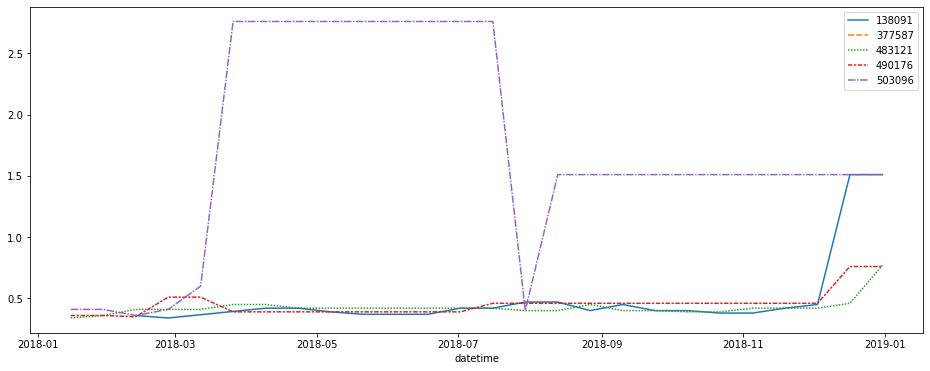

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16,6))
sns.lineplot(data=limited_period)


In [51]:
limited_period.pct_change(2)

,138091,377587,483121,490176,503096
datetime,,,,,
2018-01-15,NaN,NaN,NaN,NaN,NaN
2018-01-29,NaN,NaN,NaN,NaN,NaN
2018-02-12,NaN,NaN,0.205882,-0.027778,-0.121951
2018-02-26,NaN,NaN,0.138889,0.416667,0.000000
2018-03-12,-0.055556,NaN,0.000000,0.457143,0.666667
2018-03-26,0.000000,NaN,0.097561,-0.235294,5.731707
2018-04-09,0.235294,NaN,0.097561,-0.235294,3.600000
2018-04-23,0.235294,NaN,-0.066667,0.000000,0.000000
2018-05-07,-0.071429,NaN,-0.066667,0.000000,0.000000


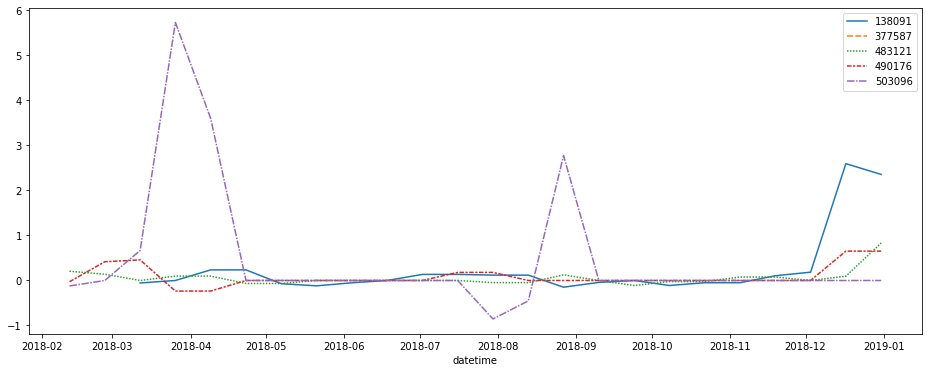

In [53]:
plt.figure(figsize=(16,6))
sns.lineplot(data=limited_period.pct_change(2))

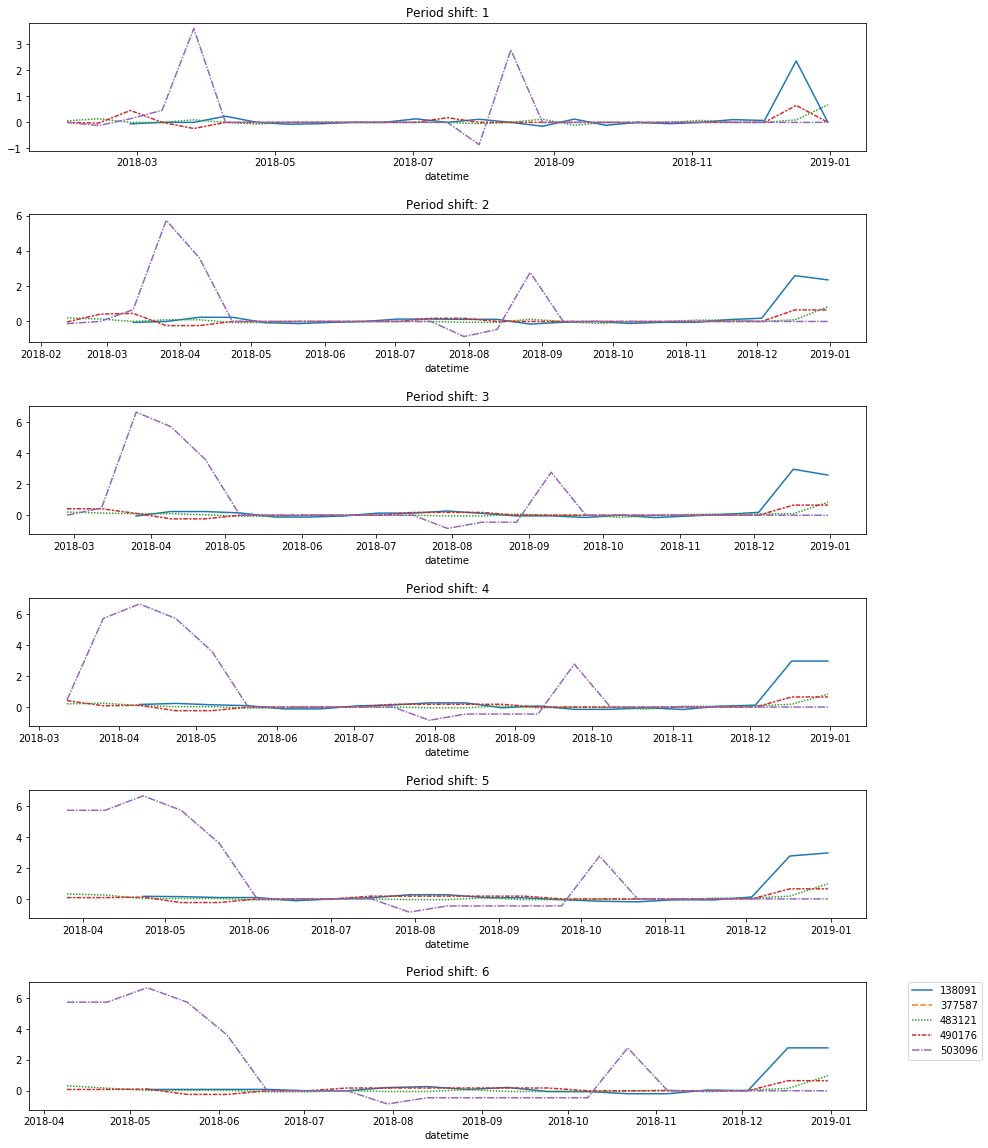

In [54]:
# fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig, axs = plt.subplots(6,1, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

period_shift = 7

data_src = [limited_period.pct_change(i) for i in range(1,period_shift)]
axs = axs.ravel()

for i in range(period_shift-1):
    
    g = sns.lineplot(data=data_src[i], ax=axs[i])
#     axs[i].set_title("Period shift: " + str(i+1))
    g.set_title("Period shift: " + str(i+1))
#     g.set_xticklabels(rotation=30)
    axs[i].legend().remove()
    
#     axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
#     axs[i].set_title(str(250+i))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [74]:
pct_change_1period = ramipril_10mg_100stk_df.pct_change()

In [76]:
ramipril_10mg_100stk_df.shape

(217, 5)

In [79]:
pct_change_1period.head()

,138091,377587,483121,490176,503096
datetime,,,,,
2011-04-18,NaN,NaN,NaN,NaN,NaN
2011-05-02,NaN,NaN,NaN,NaN,-0.088496
2011-05-16,NaN,NaN,NaN,NaN,-0.077670
2011-05-30,NaN,NaN,NaN,NaN,-0.052632
2011-06-13,NaN,NaN,NaN,NaN,0.000000


In [81]:
# find_only_one_contender(ramipril_10mg_100stk_df)

datetime
2011-04-18     True
2011-05-02     True
2011-05-16     True
2011-05-30     True
2011-06-13     True
2011-07-11     True
2011-07-25     True
2011-08-08     True
2011-08-22     True
2011-09-05     True
2011-09-19     True
2011-10-03     True
2011-10-17     True
2011-10-31     True
2011-11-14     True
2011-11-28     True
2011-12-12     True
2011-12-26     True
2012-01-09     True
2012-01-23     True
2012-02-06     True
2012-02-20     True
2012-03-05     True
2012-03-19     True
2012-04-02     True
2012-04-16     True
2012-04-30     True
2012-05-14     True
2012-05-28     True
2012-06-11     True
              ...  
2018-07-02    False
2018-07-16    False
2018-07-30    False
2018-08-13    False
2018-08-27    False
2018-09-10    False
2018-09-24    False
2018-10-08    False
2018-10-22    False
2018-11-05    False
2018-11-19    False
2018-12-03    False
2018-12-17    False
2018-12-31    False
2019-01-14    False
2019-01-28    False
2019-02-11    False
2019-02-25    False
2019-03-11 

In [86]:
pct_change_1period[find_only_one_contender(ramipril_10mg_100stk_df)].dropna(thresh=1)

,138091,377587,483121,490176,503096
datetime,,,,,
2011-05-02,NaN,NaN,NaN,NaN,-0.088496
2011-05-16,NaN,NaN,NaN,NaN,-0.077670
2011-05-30,NaN,NaN,NaN,NaN,-0.052632
2011-06-13,NaN,NaN,NaN,NaN,0.000000
2011-07-11,NaN,NaN,NaN,NaN,-0.122222
2011-07-25,NaN,NaN,NaN,NaN,-0.088608
2011-08-08,NaN,NaN,NaN,NaN,0.000000
2011-08-22,NaN,NaN,NaN,NaN,-0.194444
2011-09-05,NaN,NaN,NaN,NaN,0.000000
